<h1 class="text-center">Assignment 1</h1>

___

# Table of contents
1. [Imports](#I.-Imports)
2. [Reading data into the notebook](#II.-Reading-data-into-the-notebook)
3. [Train-Valid-Test Split](#III.-Train---Valid---Test-Split)
4. [Data Pre-processing](#IV.-Data-Pre-processing)
5. [Hyperparameter tuning](#V.-Hyperparameter-tuning)
6. [Evaluating test set accuracy with the trained model](#VI.-Evaluating-test-set-accuracy-with-the-trained-model)

## Assignment Q&A:
1. [Question 1 - Answered](#Question-1:)
1. [Question 2 - Answered](#Question-2:)

___

# I. Imports

In [1]:
import pandas as pd
import numpy as np
from pandas.api.types import is_string_dtype,is_numeric_dtype
from sklearn import preprocessing
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix,accuracy_score,matthews_corrcoef,f1_score
from sklearn.metrics import classification_report,roc_curve,roc_auc_score
from sklearn.externals import joblib
from matplotlib import pyplot as plt
import seaborn as sns
import joblib

%matplotlib inline

C:\Users\srush\Anaconda3\lib\site-packages\sklearn\externals\joblib\__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [2]:
#Check the path to the directory where you are currently in
%pwd

'C:\\Users\\srush\\Documents\\Srushti NEU\\Full Summer 2020\\INFO 6105 Data Science Engineering Methods and Tools\\Assignment'

In [3]:
'''Define a variable that points to this. This will let you avoid typing the long path everytime you need to use it'''

my_path = 'C:\\Users\\srush\\Documents\\Srushti NEU\\Full Summer 2020\\INFO 6105 Data Science Engineering Methods and Tools\\Assignment'

<a href="#Table-of-contents"><h5 class="text-center">Go to top</h5></a>

___

# II. Reading data into the notebook

In [4]:
'''Reading csv file, finding out shape(using shape()) and printing the first 5 rows using head()'''
my_df = pd.read_csv(f'{my_path}/Titanic_full.csv')
print(my_df.shape)
my_df.head(5)

(1309, 12)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


<a href="#Table-of-contents"><h5 class="text-center">Go to top</h5></a>

___

# III. Train - Valid - Test Split

In [5]:
'''70% is called a training set. 15% of the data goes into evaluating model performance as you manually 
change or set the modelhyperparameters (e.g. Value of K is a hyperparameter,in K-NN algorithm).
Also called the validation set. Finally, the last 15% of the data is the test set.  This dataset is 
never "seen" by the model for model building or hyperparamter tuning.

Calculate 15% of 1309. This is about 209 rows of data. So, 1309 - 209 = 1100 rows of data will remain for the
train and valid sets which we will separate later. 200 rows of data will go as test set data'''

def mydf_splitter(my_df,num_rows):
    return my_df[:num_rows].copy(),my_df[num_rows:]


mydf_train_valid,mydf_test = mydf_splitter(my_df,1100)

print(mydf_train_valid.shape,mydf_test.shape)

#We are going to put away the mydf_test for now. 
#We will return to it later.

(1100, 12) (209, 12)


<a href="#Table-of-contents"><h5 class="text-center">Go to top</h5></a>

___

# IV. Data Pre-processing

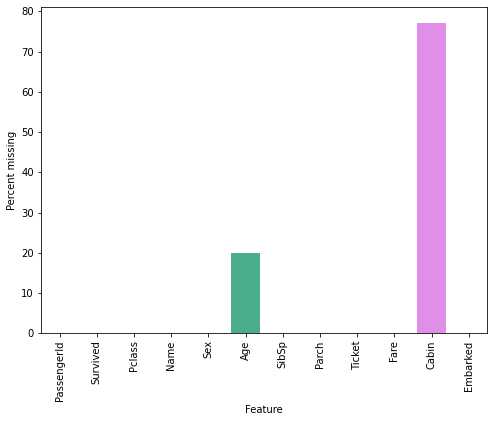

In [6]:
''' Deal with missing values:
        First, calculate the percentage of missing values for every column, 
        and plot them as a bar chart'''

null_vals = mydf_train_valid.isnull().sum()/len(mydf_train_valid)*100
null_vals = pd.DataFrame(null_vals)
null_vals.reset_index(inplace = True)
null_vals.columns = ["Feature","Percent missing"]
plt.figure(figsize = (8,6))
plt.xticks(rotation=90)
sns.barplot(x = "Feature",y ="Percent missing",data = null_vals)

> From the above plot, it looks like Cabin has ~80%missing values.
It would be meaningless to impute or fill in 80% values, so we drop the column.
We will impute age (which has ~ 20% missing, but we'll try to impute),
Fare, and Embarked column.These have very little missing values.
>
>We are going to preprocess this dataset in these steps--
>1. Convert the entire dataframe to an array of numbers. This itself is going to happen in two steps -- (a) Convert object types and string types to category type (b) map and convert cateogries of numbers.  
>  
>2. Impute or "fill in" missing values or NaNs. Here, continuous (e.g. Fare column) and categorical values are treated separately. For filling up missing continuous values, we use the median value of that column, and filling up missing categorical values, we use 0. Also, we add a separate "marker" column for both that notes whether a value has been imputed or not.  
>  
>3. Finally, for a lot of the algorithms like k-NN, we scale the data to lie between 0 and 1 with mean zero and unit variance.


In [7]:
mydf_train_valid_2 = mydf_train_valid.drop("Cabin",axis = 1)
print(mydf_train_valid_2.shape)
mydf_train_valid_2.head(2)

(1100, 11)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C


In [8]:
#Check types of each column with the dataframe info () method
mydf_train_valid_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1100 entries, 0 to 1099
Data columns (total 11 columns):
PassengerId    1100 non-null int64
Survived       1100 non-null int64
Pclass         1100 non-null int64
Name           1100 non-null object
Sex            1100 non-null object
Age            881 non-null float64
SibSp          1100 non-null int64
Parch          1100 non-null int64
Ticket         1100 non-null object
Fare           1099 non-null float64
Embarked       1098 non-null object
dtypes: float64(2), int64(5), object(4)
memory usage: 94.7+ KB


In [9]:
'''You can see that several of the columns or features are "object" type. There need to be changed to category before 
we can convert those to mappings and numbers'''
    
#1 (a) Define a function to convert object types and string types to category type

def str_to_cat(my_df):
    for p,q in my_df.items(): #my_df.items() is a generator in Python
        if is_string_dtype(q): 
            my_df[p] = q.astype('category').cat.as_ordered()
    return my_df

In [10]:
mydf_train_valid_3 = str_to_cat(mydf_train_valid_2)
print(mydf_train_valid_3)

      PassengerId  Survived  Pclass  \
0               1         0       3   
1               2         1       1   
2               3         1       3   
3               4         1       1   
4               5         0       3   
...           ...       ...     ...   
1095         1096         1       2   
1096         1097         0       1   
1097         1098         0       3   
1098         1099         1       2   
1099         1100         1       1   

                                                   Name     Sex   Age  SibSp  \
0                               Braund, Mr. Owen Harris    male  22.0      1   
1     Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                                Heikkinen, Miss. Laina  female  26.0      0   
3          Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                              Allen, Mr. William Henry    male  35.0      0   
...                                                

In [11]:
#Check dtypes of columns after this operation
mydf_train_valid_3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1100 entries, 0 to 1099
Data columns (total 11 columns):
PassengerId    1100 non-null int64
Survived       1100 non-null int64
Pclass         1100 non-null int64
Name           1100 non-null category
Sex            1100 non-null category
Age            881 non-null float64
SibSp          1100 non-null int64
Parch          1100 non-null int64
Ticket         1100 non-null category
Fare           1099 non-null float64
Embarked       1098 non-null category
dtypes: category(4), float64(2), int64(5)
memory usage: 161.8 KB


In [12]:
'''Check the cateogry mapping for Embarked and Sex column. We need this later'''
print(mydf_train_valid_3.Embarked.cat.categories)
print(mydf_train_valid_3.Sex.cat.categories)

Index(['C', 'Q', 'S'], dtype='object')
Index(['female', 'male'], dtype='object')


>All object categories like Name, Sex, and Ticket have been converted to
Category dtype !

In [13]:
'''Define impute functions:
    Impute categorical NaNs with -1, where we add 1 to make it 0. 
    For each continuous variables, we impute missing values with median values of that column, 
    and for every variable where any rows were imputed, add a separate 'imputed or not' column'''

def mydf_to_nums(my_df, feature, null_status):
    if not is_numeric_dtype(feature):
        my_df[null_status] = feature.cat.codes + 1
        
def mydf_imputer(my_df, feature, null_status, null_table):
    if is_numeric_dtype(feature):
        if pd.isnull(feature).sum() or (null_status in null_table):
            my_df[null_status+'_na'] = pd.isnull(feature)
            filler = null_table[null_status] if null_status in null_table else feature.median()
            my_df[null_status] = feature.fillna(filler)
            null_table[null_status] = filler
    return null_table   

def mydf_preprocessor(my_df, null_table):
    '''null_table  = your table or None'''
    
    if null_table is None: 
        null_table = dict()
    for p,q in my_df.items(): 
        null_table = mydf_imputer(my_df, q, p, null_table)
    for p,q in my_df.items(): 
        mydf_to_nums(my_df, q, p)
    my_df = pd.get_dummies(my_df, dummy_na = True)
    res = [my_df, null_table]
    return res

In [14]:
mydf_train_valid_4,my_table = mydf_preprocessor(mydf_train_valid_3,null_table = None)

In [15]:
mydf_train_valid_4.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Age_na,Fare_na
0,1,0,3,135,2,22.0,1,0,629,7.2500,3,False,False
1,2,1,1,245,1,38.0,1,0,713,71.2833,1,False,False
2,3,1,3,442,1,26.0,0,0,799,7.9250,3,False,False


In [16]:
'''Please store the null_table, category mapping separately. 
    We will need to process the test dataset using these values'''

my_table

{'Age': 28.0, 'Fare': 14.4583}

In [17]:
'''Now, let's separate the X and Y variables (vertical split of the dataframe). 
    Here the Y column is the variable we are trying to predict, survived or not(0 = No, 1 = Yes)'''

Y = mydf_train_valid_4["Survived"]
X = mydf_train_valid_4.drop(["Survived"],axis = 1)

print(X.shape,Y.shape)

(1100, 12) (1100,)


In [18]:
X_cat = X[['PassengerId', 'Pclass', 'Name', 'Sex', 'SibSp', 'Parch',
       'Ticket', 'Embarked', 'Age_na', 'Fare_na']]
X_con = X.drop(X_cat,axis = 1)
print(X_cat.shape,X_con.shape)

(1100, 10) (1100, 2)


In [19]:
scaler = preprocessing.StandardScaler().fit(X_con)
X_con_sc = pd.DataFrame(scaler.transform(X_con))
X_con_sc.columns = ["Age","Fare"]
print(X_con_sc.shape)
X_con_sc.head(2)

(1100, 2)


,Age,Fare
0,-0.574896,-0.502155
1,0.659705,0.747957


In [20]:
df_list = [X_cat,X_con_sc]
X_full = pd.concat(df_list,axis = 1)
print(X_full.shape)
X_full.head(2)

(1100, 12)


,PassengerId,Pclass,Name,Sex,SibSp,Parch,Ticket,Embarked,Age_na,Fare_na,Age,Fare
0,1,3,135,2,1,0,629,3,False,False,-0.574896,-0.502155
1,2,1,245,1,1,0,713,1,False,False,0.659705,0.747957


In [21]:
'''Then, split into train and valid sets for model building and hyperparameter tuning, respectively 
    
    !Remember, we need to split (horizontally the rows) X_full into train and validation sets. 
    We use the dataframe splitter function we defined previously. 
    Strictly for later use in another module, merge X and Y and store.
    Save it as train data.'''

X_train,X_valid = mydf_splitter(X_full,900)
Y_train,Y_valid = mydf_splitter(Y,900)

print(X_train.shape,X_valid.shape,Y_train.shape,Y_valid.shape)


(900, 12) (200, 12) (900,) (200,)


In [22]:
'''Time for training the model and evaluating it on the validation set. 
    At first, let's use the default values for the kNN hyperparameters -
    (n_neighbors = 3,weights = 'uniform'). 
    KNN has more hyperparameters such as leaf_size, metric, etc. 
    But, these two are key hyperparamters'''

my_knn_model = KNeighborsClassifier(n_neighbors = 5,weights = 'uniform')
my_knn_model.fit(X_train,Y_train)

#Predict on the validation set
Y_pred = my_knn_model.predict(X_valid)

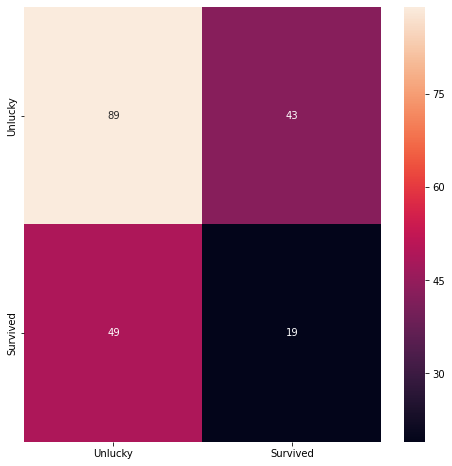

In [23]:
# Plot confusion matrix
from sklearn.metrics import confusion_matrix

my_knn_cmatrix = confusion_matrix(Y_valid,Y_pred)
my_knn_df = pd.DataFrame(my_knn_cmatrix)

plt.figure(figsize = (8,8))
x_axis_labels = ["Unlucky","Survived"] # labels for x-axis
y_axis_labels = ["Unlucky","Survived"] # labels for y-axis

plt.yticks(va="center")

# create seabvorn heatmap with required labels
sns.heatmap(my_knn_df, xticklabels=x_axis_labels, yticklabels=y_axis_labels, annot=True)

In [24]:
print(accuracy_score(Y_valid,Y_pred),
      matthews_corrcoef(Y_valid,Y_pred),f1_score(Y_valid,Y_pred))

#An MCC of -0.0474 looks bad !We need to do model tuning or 
#hyperparameter tuning to try to make it better

0.54 -0.0474697036788388 0.29230769230769227


<a href="#Table-of-contents"><h5 class="text-center">Go to top</h5></a>

___

# V. Hyperparameter tuning

> # Question 1:
>>The K nearest neighbor algorithm has hyper-parameters in addition to K. Use the titanic dataset to simultaneously tune the values of more than one hyper-parameter. E.g. Value of K, weight, and metric. You can either do nested for loops for this or use the grid search OR random search function from scikit-learn.

In [25]:
#Implementing GridSearch for tuning hyperparameter
from sklearn.model_selection  import GridSearchCV
import time

'''Creating a parameter grid: map the parameter names to the values that should be searched.
    
    Here: in Params using arange method to create a list of numbers from 1 till 101
    and skipping 2 i.e. considering all odd numbers'''

params = {"n_neighbors": np.arange(1, 101, 2),
          "weights":['uniform','distance'],
        "metric": ["euclidean", "cityblock"]}

my_knn_model = KNeighborsClassifier()

# Instantiate the grid
grid = GridSearchCV(my_knn_model, params,verbose=1,cv=3,n_jobs=-1) 
start = time.time()

# Fit the grid with data
grid_result = grid.fit(X_train,Y_train)                           

# Printing Time taken for the search
print("Grid search took {:.2f} seconds".format(time.time() - start))

# Printing Grid search accuracy for the hyperparameters selecte by the grid
acc = grid.score(X_train,Y_train)
print("Grid search accuracy: {:.2f}%".format(acc * 100))

# Printing Grid search hyperparameters selected
print("Grid search best parameters: {}".format(grid.best_params_))

#Predict on the validation set
Y_pred = grid.predict(X_valid)

Fitting 3 folds for each of 200 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.3s


Grid search took 5.21 seconds
Grid search accuracy: 100.00%
Grid search best parameters: {'metric': 'cityblock', 'n_neighbors': 39, 'weights': 'distance'}


[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:    5.1s finished


In [26]:
grid.best_score_
grid_result

GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid='warn', n_jobs=-1,
             param_grid={'metric': ['euclidean', 'cityblock'],
                         'n_neighbors': array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33,
       35, 37, 39, 41, 43, 45, 47, 49, 51, 53, 55, 57, 59, 61, 63, 65, 67,
       69, 71, 73, 75, 77, 79, 81, 83, 85, 87, 89, 91, 93, 95, 97, 99]),
                         'weights': ['uniform', 'distance']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=1)

In [27]:
# view the complete results (list of named tuples)
grid.cv_results_

{'mean_fit_time': array([0.0067145 , 0.00701388, 0.0069859 , 0.00767756, 0.007339  ,
        0.00729044, 0.00766905, 0.00731643, 0.00472959, 0.00859714,
        0.00598303, 0.00805306, 0.00565108, 0.00531896, 0.00443554,
        0.00759848, 0.006615  , 0.00726628, 0.00865753, 0.00731095,
        0.00893148, 0.0083131 , 0.00767152, 0.00828242, 0.00723251,
        0.00760333, 0.00562962, 0.00631475, 0.01023698, 0.00604781,
        0.00468127, 0.00600235, 0.0053579 , 0.00498112, 0.00631412,
        0.00430346, 0.00565187, 0.00465552, 0.00496467, 0.00398827,
        0.00470662, 0.00465417, 0.00983477, 0.00469065, 0.00434208,
        0.00548704, 0.00397102, 0.00397905, 0.00568604, 0.00399915,
        0.00646408, 0.00401775, 0.00501434, 0.00398993, 0.0047094 ,
        0.00432285, 0.00769051, 0.00431053, 0.0053761 , 0.00466077,
        0.00467658, 0.00470893, 0.00399343, 0.00459409, 0.00533525,
        0.00548283, 0.00536052, 0.00401155, 0.00399836, 0.00970038,
        0.00656017, 0.00442052,

In [28]:
# Plot confusion matrix
from sklearn.metrics import confusion_matrix

my_knn_cmatrix = confusion_matrix(Y_valid,Y_pred)

my_knn_df = pd.DataFrame(my_knn_cmatrix)
my_knn_df.head()

,0,1
0,101,31
1,53,15


In [29]:
'''Rename indices and columns, and transpose the dataframe so that
actual items are plotted on the x-axis, and predicted on the y-axis'''

my_knn_df.columns = ["Did not Survive","Survived"]
my_knn_df.index = ["Did not Survive","Survived"]
my_knn_df = my_knn_df.T
my_knn_df

,Did not Survive,Survived
Did not Survive,101,53
Survived,31,15


(array([0.5, 1.5]), <a list of 2 Text major ticklabel objects>)

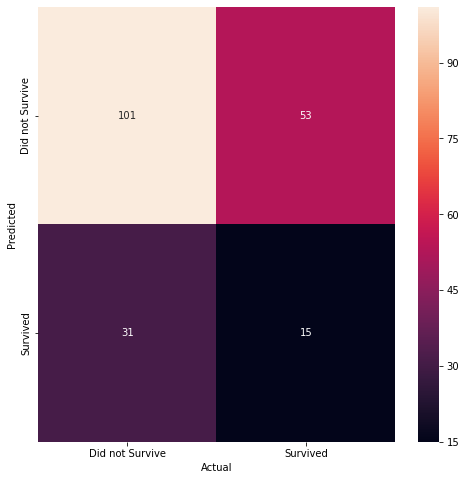

In [30]:
# Make a heatmap of the confusion matrix with seaborn
plt.figure(figsize = (8,8))
akws = {"ha": 'center',"va": 'center'}
sns.heatmap(my_knn_df, 
            annot = True, fmt='g', annot_kws=akws)
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.yticks(va="center")

In [31]:
#Calculate accuracy
print(accuracy_score(Y_valid,Y_pred),
      matthews_corrcoef(Y_valid,Y_pred),
      f1_score(Y_valid,Y_pred))

0.58 -0.0160520044490449 0.2631578947368421


In [32]:
#Calculate precision, recall, f1-score in function built in scikit-learn 
scores = classification_report(Y_valid,Y_pred)
print(scores)

              precision    recall  f1-score   support

           0       0.66      0.77      0.71       132
           1       0.33      0.22      0.26        68

    accuracy                           0.58       200
   macro avg       0.49      0.49      0.48       200
weighted avg       0.54      0.58      0.56       200



In [33]:
knn_model_fin = KNeighborsClassifier(n_neighbors= 39, weights= 'distance',metric= 'cityblock')
knn_model_fin.fit(X_full,Y)

!mkdir knn_model
knn_model_name = f'{my_path}\\knn_model\\knn_model_final.sav'
joblib.dump(knn_model_fin,knn_model_name)

A subdirectory or file knn_model already exists.


['C:\\Users\\srush\\Documents\\Srushti NEU\\Full Summer 2020\\INFO 6105 Data Science Engineering Methods and Tools\\Assignment\\knn_model\\knn_model_final.sav']

In [34]:
#Make sure your model has been saved !
!ls knn_model

knn_model_final.sav


In [35]:
# Congrats! You have saved your model!Now, let's read it back in!
knn_model_loaded = joblib.load(knn_model_name)

<a href="#Table-of-contents"><h5 class="text-center">Go to top</h5></a>

___

# VI. Evaluating test set accuracy with the trained model

In [36]:
'''Before we can apply this on the test set, we need to pre-process the test set in exactly the same way we did the
train_valid set !!!'''

print(mydf_test.shape)
mydf_test.head(3)


(209, 12)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
1100,1101,1,3,"Delalic, Mr. Redjo",male,25.0,0,0,349250,7.8958,NaN,S
1101,1102,0,3,"Andersen, Mr. Albert Karvin",male,32.0,0,0,C 4001,22.5250,NaN,S
1102,1103,1,3,"Finoli, Mr. Luigi",male,NaN,0,0,SOTON/O.Q. 3101308,7.0500,NaN,S


In [37]:
#get rid of the "cabin" column as we did before with the train_valid set
mydf_test1 = mydf_test.drop("Cabin",axis = 1)
print(mydf_test1.shape)
mydf_test1.head(3)

(209, 11)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
1100,1101,1,3,"Delalic, Mr. Redjo",male,25.0,0,0,349250,7.8958,S
1101,1102,0,3,"Andersen, Mr. Albert Karvin",male,32.0,0,0,C 4001,22.5250,S
1102,1103,1,3,"Finoli, Mr. Luigi",male,NaN,0,0,SOTON/O.Q. 3101308,7.0500,S


In [38]:
'''Make sure the category codes for train and test sets are the same as 
the ones we used previously! Here, we have coded, Name, Sex, Ticket and 
embarked. Because Name and Ticket ids will not be repeated, 
we will check Sex and embarked. Checking category codes for the test set...'''

mydf_test2 = str_to_cat(mydf_test1)
mydf_test2.Sex.cat.categories

Index(['female', 'male'], dtype='object')

In [39]:
#Check for the Embarked column
mydf_test2.Embarked.cat.categories

Index(['C', 'Q', 'S'], dtype='object')

In [40]:
#Cool, this means the category codes are the same. We can proceed.
#Make sure you use the same impute values of median.
mydf_test3,my_table1 = mydf_preprocessor(mydf_test2,
                                         null_table = my_table)
print(mydf_test3.shape)
mydf_test3.head(3)

(209, 13)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Age_na,Fare_na
1100,1101,1,3,47,2,25.0,0,0,106,7.8958,3,False,False
1101,1102,0,3,6,2,32.0,0,0,146,22.5250,3,False,False
1102,1103,1,3,62,2,28.0,0,0,187,7.0500,3,True,False


In [41]:
my_table1

{'Age': 28.0, 'Fare': 14.4583}

In [42]:
# Now, let's split out the X and Y variables (vertical split of the dataframe)
#Remember we did this previously!


Y_t = mydf_test3["Survived"]
X_t = mydf_test3.drop(["Survived"],axis = 1)

print(X_t.shape,Y_t.shape)

(209, 12) (209,)


In [43]:
#Separate continuous and categorical variables/columns for scaling

X_cat_t = X_t[['PassengerId', 'Pclass', 'Name', 'Sex', 'SibSp', 'Parch',
       'Ticket', 'Embarked', 'Age_na', 'Fare_na']]
X_con_t = X_t.drop(X_cat_t,axis = 1)
print(X_cat_t.shape,X_con_t.shape)

(209, 10) (209, 2)


In [44]:
'''Scale using the training set mean and SD. This is already captured in
the scaler object we made. Else, save that in a joblib dump too to reload'''

X_con_sct = pd.DataFrame(scaler.transform(X_con_t))
X_con_sct.columns = ["Age","Fare"]
print(X_con_sct.shape)
X_con_sct.head(2)


(209, 2)


,Age,Fare
0,-0.343408,-0.489547
1,0.196729,-0.203944


In [45]:
print(X_cat_t.shape,X_con_sct.shape)

(209, 10) (209, 2)


In [46]:
#Re-index before merging
X_cat_t.reset_index(inplace = True,drop = False)

In [47]:
X_cat_t.head()

,index,PassengerId,Pclass,Name,Sex,SibSp,Parch,Ticket,Embarked,Age_na,Fare_na
0,1100,1101,3,47,2,0,0,106,3,False,False
1,1101,1102,3,6,2,0,0,146,3,False,False
2,1102,1103,3,62,2,0,0,187,3,True,False
3,1103,1104,2,45,2,0,0,179,3,False,False
4,1104,1105,2,91,1,1,0,38,3,False,False


In [48]:
X_cat_t.drop("index",inplace = True,axis = 1)
X_cat_t.head(2)

C:\Users\srush\Anaconda3\lib\site-packages\pandas\core\frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,PassengerId,Pclass,Name,Sex,SibSp,Parch,Ticket,Embarked,Age_na,Fare_na
0,1101,3,47,2,0,0,106,3,False,False
1,1102,3,6,2,0,0,146,3,False,False


In [49]:
#Merge the two sets of columns
df_list_I = [X_cat_t,X_con_sct]
X_test_I = pd.concat(df_list_I,axis = 1)
print(X_test_I.shape)
X_test_I.head(2)

(209, 12)


,PassengerId,Pclass,Name,Sex,SibSp,Parch,Ticket,Embarked,Age_na,Fare_na,Age,Fare
0,1101,3,47,2,0,0,106,3,False,False,-0.343408,-0.489547
1,1102,3,6,2,0,0,146,3,False,False,0.196729,-0.203944


In [50]:
#Now we are ready to test it out. Let's load the saved model first.
kNN_loaded = joblib.load(f'{my_path}/knn_model/knn_model_final.sav')

In [51]:
#Testing...
Y_test_pred = kNN_loaded.predict(X_test_I)

In [52]:
print(accuracy_score(Y_t,Y_test_pred),
      matthews_corrcoef(Y_t,Y_test_pred),f1_score(Y_t,Y_test_pred))

0.5550239234449761 -0.08631961956314592 0.0


In [53]:
scores = classification_report(Y_t,Y_test_pred)
print(scores)

              precision    recall  f1-score   support

           0       0.56      0.98      0.71       118
           1       0.00      0.00      0.00        91

    accuracy                           0.56       209
   macro avg       0.28      0.49      0.36       209
weighted avg       0.32      0.56      0.40       209



<a href="#Table-of-contents"><h5 class="text-center">Go to top</h5></a>

___

# Receiver Operating Characteristic (ROC) and Area Under the Curve (AUC)

In [54]:
rec, fall_out, thresholds = roc_curve(Y_t,Y_test_pred)

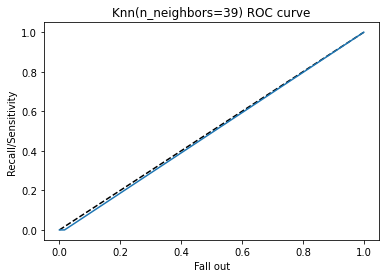

In [55]:
plt.plot([0,1],[0,1],'k--')
plt.plot(rec,fall_out, label='Knn')
plt.xlabel('Fall out')
plt.ylabel('Recall/Sensitivity')
plt.title('Knn(n_neighbors=39) ROC curve')
plt.show()

In [56]:
#Area under ROC curve
roc_auc_score(Y_t,Y_test_pred)

0.4915254237288136

In [57]:
'''Write out full train_valid and test dataframes for later use in module.'''
X_full["Survived"] = Y
X_test_I["Survived"] = Y_t

print(X_full.shape)
print(X_test_I.shape)

(1100, 13)
(209, 13)


<a href="#Table-of-contents"><h5 class="text-center">Go to top</h5></a>

___

# Question 2: 
#### What do you think some of the disadvantages of k-NN algorithm are?

  **1. K-NN slow algorithm:** K-NN might be very easy to implement but as dataset grows efficiency or speed of algorithm declines very fast. In large datasets, the cost of calculating the distance between the new point and each existing points is huge which degrades the performance of the algorithm.
  
  **2. Curse of Dimensionality:** KNN works well with small number of input variables but as the numbers of variables grow K-NN algorithm struggles to predict the output of new data point.
    
   **3. K-NN needs homogeneous features:** If you decide to build k-NN using a common distance, like Euclidean or Manhattan distances, it is completely necessary that features have the same scale, since absolute differences in features weight the same, i.e., a given distance in feature 1 must means the same for feature 2.
    
   **4. Optimal number of neighbors:** One of the biggest issues with K-NN is to choose the optimal number of neighbors to be consider while classifying the new data entry.
    
   **5. Imbalanced data causes problems:** k-NN doesn’t perform well on imbalanced data. If we consider two classes, A and B, and the majority of the training data is labeled as A, then the model will ultimately give a lot of preference to A. This might result in getting the less common class B wrongly classified.
    
   **6. Outlier sensitivity:** K-NN algorithm is very sensitive to outliers as it simply chose the neighbors based on distance criteria.  We need to manually impute missing values and remove outliers.
   
   **7. Missing Value treatment:** K-NN inherently has no capability of dealing with missing value problem.
   
   **8.Need feature scaling:** We need to do feature scaling (standardization and normalization) before applying KNN algorithm to any dataset. If we don't do so, KNN may generate wrong prediction.

<a href="#Table-of-contents"><h5 class="text-center">Go to top</h5></a>

___